In [1]:
import fastf1 as f1
import fastf1.plotting
import matplotlib.pyplot as plt
import numpy as np
fastf1.plotting.setup_mpl()
import datetime
import os


fastf1.Cache.enable_cache(os.getcwd())

In [2]:
now = datetime.date.today().strftime('%Y-%m-%d')
print(f"The date today is: {now}\nThe races that have already happened are the following:")
schedule = f1.get_event_schedule(2024)
schedule_to_date = schedule[schedule.EventDate<now]
schedule_to_date = schedule_to_date[schedule_to_date.RoundNumber>0]
print(f"{schedule_to_date[['Location','EventDate']].to_string(index=False, header=False)}")
n=max(schedule_to_date['RoundNumber'])+1
print(f"---Next Race---\n{schedule.Location.loc[n]} {schedule.EventDate.loc[n].strftime('%Y-%m-%d')}")

The date today is: 2024-05-03
The races that have already happened are the following:
   Sakhir 2024-03-02
   Jeddah 2024-03-09
Melbourne 2024-03-24
   Suzuka 2024-04-07
 Shanghai 2024-04-21
---Next Race---
Miami 2024-05-05


In [7]:
session_name='Miami'

session = f1.get_session(2024,session_name, 'Race')
session.load(telemetry=False, weather=False)

core           INFO 	Loading data for Miami Grand Prix - Race [v3.3.5]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to load extended driver information!


KeyError: 'DriverNumber'

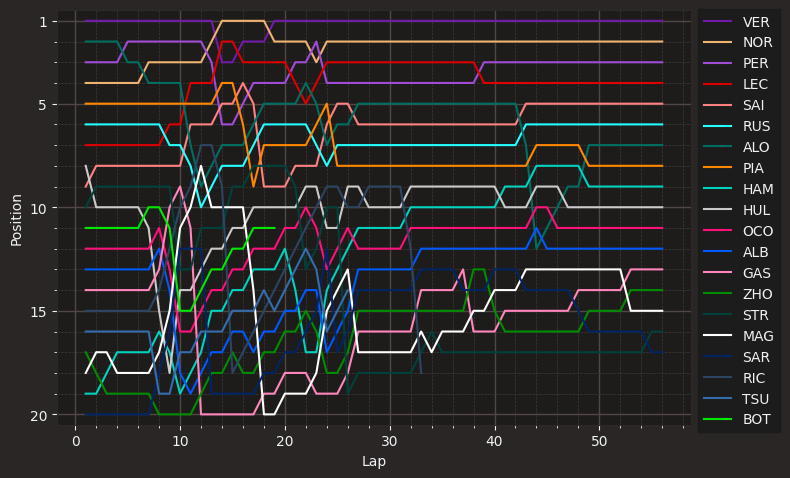

In [4]:
## Here we are going to plot position changes during Suzuka
fastf1.plotting.setup_mpl(misc_mpl_mods=False)

fig,ax=plt.subplots(figsize=(8,4.9))
for driver in session.drivers:
    driver_laps = session.laps.pick_driver(driver)
    name_abbr = driver_laps['Driver'].iloc[0] ## 3 lettername abbreviation in laps format
    color= fastf1.plotting.driver_color(name_abbr)
    ax.plot(driver_laps['LapNumber'], driver_laps['Position'], label=name_abbr, color=color)

ax.set_ylim([20.5, 0.5])
ax.set_yticks([1, 5, 10, 15, 20])
ax.set_xlabel('Lap')
ax.set_ylabel('Position')

ax.legend(bbox_to_anchor=(1.0, 1.02))
plt.tight_layout()

plt.show()


In [5]:

session.total_laps

56

In [20]:
## Get and organize lap stint data
all_laps=session.laps
drivers=session.drivers
drivers=[session.get_driver(drvr)["Abbreviation"] for drvr in drivers] # get abbr

finishing_order = [session.get_driver(i)["Abbreviation"] for i in session.drivers]

stints = all_laps[["Driver", "Stint", "Compound", "LapNumber"]] # only data we are curious in
stints = stints.groupby(["Driver", "Stint", "Compound"]) # group first by driver, then by stint, then by compound
stints = stints.count().reset_index() # replace index with length of stints
stints = stints.rename(columns={"LapNumber":"StintLength"}) # change index header to new name

In [26]:
print(finishing_order)

['VER', 'NOR', 'PER', 'LEC', 'SAI', 'RUS', 'ALO', 'PIA', 'HAM', 'HUL', 'OCO', 'ALB', 'GAS', 'ZHO', 'STR', 'MAG', 'SAR', 'RIC', 'TSU', 'BOT']


In [15]:
print()

Time                  0 days 02:18:37.392000
Driver                                   ALO
DriverNumber                              14
LapTime               0 days 00:01:37.810000
LapNumber                               45.0
Stint                                    4.0
PitOutTime                               NaT
PitInTime                                NaT
Sector1Time           0 days 00:00:26.106000
Sector2Time           0 days 00:00:29.306000
Sector3Time           0 days 00:00:42.398000
Sector1SessionTime    0 days 02:17:25.669000
Sector2SessionTime    0 days 02:17:54.975000
Sector3SessionTime    0 days 02:18:37.373000
SpeedI1                                276.0
SpeedI2                                261.0
SpeedFL                                259.0
SpeedST                                332.0
IsPersonalBest                          True
Compound                              MEDIUM
TyreLife                                 2.0
FreshTyre                               True
Team      

ALO


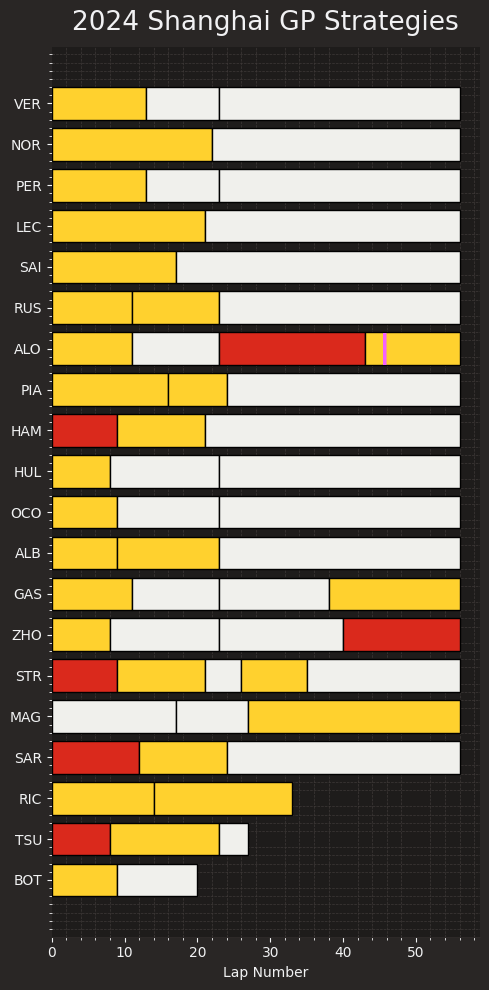

In [48]:
fix, ax=plt.subplots(figsize=(5,10))
for driver in drivers:
    driver_stints = stints.loc[stints["Driver"]==driver]
    prev_stint_end=0

    for idx, row in driver_stints.iterrows():
        #plt stacked bar horizontally
        plt.barh(y=driver, 
                    width=row["StintLength"], 
                    left=prev_stint_end, 
                    color=fastf1.plotting.COMPOUND_COLORS[row["Compound"]], #tirecolor
                    edgecolor="black", 
                    fill=True)
        prev_stint_end+=row["StintLength"]
plt.title(f"2024 {session_name} GP Strategies")
plt.xlabel("Lap Number")
plt.grid(False)
print(finishing_order[6])
text_y = finishing_order.index(all_laps.pick_fastest()['Driver'])
plt.text(x=all_laps.pick_fastest()['LapNumber'], y=text_y+0.2, s="|", fontsize=23, fontweight='bold', color='#F461FF')

ax.invert_yaxis() # invert y-axis so drivers that finish higher are closer to the top
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tight_layout()
plt.show()

In [8]:
## Laptime Distribution ##
all_driver_laps = session.laps.pick_drivers(drivers).pick_quicklaps()
all_driver_laps = all_driver_laps.reset_index()
driver_colors = {abv: fastf1.plotting.DRIVER_COLORS[driver] for abv,
                 driver in fastf1.plotting.DRIVER_TRANSLATE.items()}
results=session.results[['Abbreviation', 'ClassifiedPosition']]
results['Abbreviation']

1     VER
4     NOR
11    PER
16    LEC
55    SAI
63    RUS
14    ALO
81    PIA
44    HAM
27    HUL
31    OCO
23    ALB
10    GAS
24    ZHO
18    STR
20    MAG
2     SAR
3     RIC
22    TSU
77    BOT
Name: Abbreviation, dtype: object

In [9]:
import seaborn as sns

In [10]:
def plot_driver_laptime_distribution(driver_laps, finishing_order, driver_colors):
    fig, ax = plt.subplots(figsize=(12, 5))
    all_driver_laps["LapTime(s)"] = all_driver_laps["LapTime"].dt.total_seconds()
    violin= sns.violinplot(data=driver_laps,
                x="Driver",
                y="LapTime(s)",
                width=1,
                dodge=False,
                hue="Driver",
                order=finishing_order,
                hue_order=finishing_order,
                palette=driver_colors,
                whiskerprops=dict(color='white'),
                capprops=dict(color='white')
                )
    # Identify location of correct violins
    """ for i, violin_collection in enumerate(violin.collections):
        print("Violin", i+1, ":", violin_collection)
        if i%2==0:
            violin.collections[i].set_alpha(0) """

    # Show spread of laptimes by tire type
    """ sns.swarmplot(data=driver_laps,
                x="Driver",
                y="LapTime(s)",
                order=finishing_order,
                hue="Compound",
                palette=fastf1.plotting.COMPOUND_COLORS,
                hue_order=["SOFT", "MEDIUM", "HARD"],
                linewidth=0,
                size=3,
                ) """

    # Drivers who DNF'd have reduced opacity
    for d in range(len(finishing_order)):
        drvr=finishing_order[d]
        n = np.where(results['Abbreviation']==drvr)[0][0]
        if results['ClassifiedPosition'][d]=='R':
            #print(f"{d} {results['Abbreviation'][d]}")
            violin.collections[2*d].set_alpha(0.3)

    ax.set_xlabel("Driver")
    ax.set_ylabel("Lap Time (s)")
    plt.suptitle(f"2024 {session_name} Grand Prix Lap Time Distributions")
    ax.legend(bbox_to_anchor=(1.10, 1.02))
    plt.show()

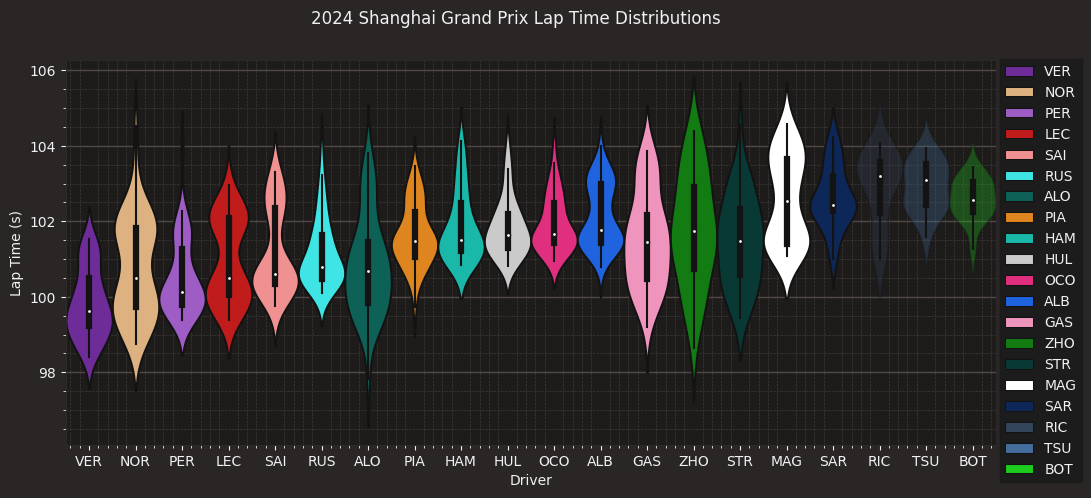

In [11]:
plot_driver_laptime_distribution(all_driver_laps, finishing_order, driver_colors)

In [13]:
def plot_driver_laptime_distribution_by_tire(driver_laps, finishing_order, driver_colors):
    fig, ax = plt.subplots(figsize=(12, 5))
    all_driver_laps["LapTime(s)"] = all_driver_laps["LapTime"].dt.total_seconds()
    """ violin= sns.violinplot(data=driver_laps,
                x="Driver",
                y="LapTime(s)",
                width=1,
                dodge=False,
                hue="Driver",
                order=finishing_order,
                hue_order=finishing_order,
                palette=driver_colors,
                whiskerprops=dict(color='white'),
                capprops=dict(color='white')
                ) """
    # Identify location of correct violins
    """ for i, violin_collection in enumerate(violin.collections):
        print("Violin", i+1, ":", violin_collection)
        if i%2==0:
            violin.collections[i].set_alpha(0) """

    # Show spread of laptimes by tire type
    sns.swarmplot(data=driver_laps,
                x="Driver",
                y="LapTime(s)",
                order=finishing_order,
                hue="Compound",
                palette=fastf1.plotting.COMPOUND_COLORS,
                hue_order=["SOFT", "MEDIUM", "HARD"],
                linewidth=0,
                size=3,
                )

    # Drivers who DNF'd have reduced opacity
    """ for d in range(len(finishing_order)):
        drvr=finishing_order[d]
        n = np.where(results['Abbreviation']==drvr)[0][0]
        if results['ClassifiedPosition'][d]=='R':
            #print(f"{d} {results['Abbreviation'][d]}")
            violin.collections[2*d].set_alpha(0.3) """

    ax.set_xlabel("Driver")
    ax.set_ylabel("Lap Time (s)")
    plt.suptitle(f"2024 {session_name} Grand Prix Lap Time Distributions")
    ax.legend(bbox_to_anchor=(1.10, 1.02))
    plt.show()

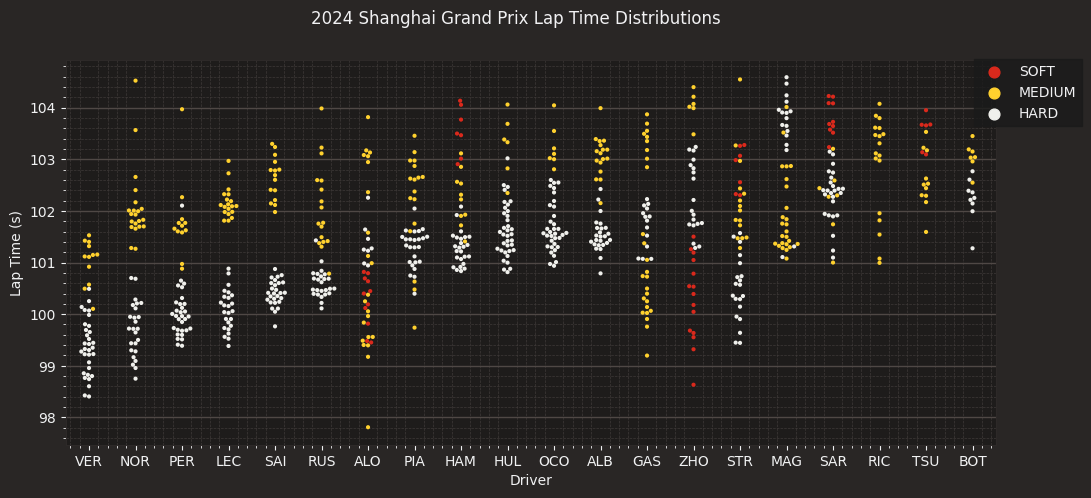

In [14]:
plot_driver_laptime_distribution_by_tire(all_driver_laps, finishing_order, driver_colors)

In [3]:
fastf1.Cache.clear_cache()